In [ ]:
import random
from collections import Counter

# Function to parse annotations and balance the class distribution with an image limit
def parse_and_balance_annotations(annotation_file, labels, margin=0.5, min_instances=20, min_target=20, max_images=None):
    annotations = []
    with open(annotation_file, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split(',')
            img_path = parts[0]
            x1, y1, x2, y2 = map(int, parts[1:5])
            class_name = parts[5]
            annotations.append((img_path, (x1, y1, x2, y2), class_name))

    # Count occurrences of each class
    class_counts = Counter([ann[2] for ann in annotations])
    sorted_counts = sorted(class_counts.values())
    second_min_class_count = sorted_counts[2] if len(sorted_counts) > 1 else sorted_counts[0]
    effective_min_class_count = max(second_min_class_count, min_instances)
    target_instances = max(int(effective_min_class_count * (1 + margin)), min_target)

    print(f"Class counts before balancing: {dict(class_counts)}")
    print(f"Effective minimum class count (second smallest): {effective_min_class_count}")
    print(f"Target instances per class: {target_instances}")

    # Filter annotations to balance the dataset with the max_images limit
    balanced_annotations = []
    reduced_classes = set()
    image_count = 0

    for cls in labels:
        class_annotations = [ann for ann in annotations if ann[2] == cls]

        if cls in reduced_classes:
            print(f"Skipping reduction for {cls}, already reduced.")
            continue

        if len(class_annotations) > target_instances:
            sampled_annotations = random.sample(class_annotations, target_instances)
            balanced_annotations.extend(sampled_annotations)
            reduced_classes.add(cls)
            print(f"Reduced {cls} from {len(class_annotations)} to {len(sampled_annotations)} samples")
        else:
            balanced_annotations.extend(class_annotations)
            print(f"No reduction needed for {cls}, instances kept: {len(class_annotations)}")

        # Limit the total number of images
        image_count += len(class_annotations)
        if max_images and image_count >= max_images:
            balanced_annotations = balanced_annotations[:max_images]
            print(f"Reached max_images limit: {max_images}")
            break

    # Count occurrences after balancing
    balanced_counts = Counter([ann[2] for ann in balanced_annotations])
    print(f"Class counts after balancing: {dict(balanced_counts)}")

    return balanced_annotations

# Modified `get_dataset` function that uses balanced annotations and an image limit
def get_dataset(annotation_file, image_base_path, labels, margin=0.5, max_images=None):
    # Parse and balance annotations with max_images limit
    balanced_annotations = parse_and_balance_annotations(annotation_file, labels, margin, max_images=max_images)

    def gen_element():
        for img_path, bbox, class_name in balanced_annotations:
            img_full_path = os.path.join(image_base_path, img_path)
            img = cv2.imread(img_full_path)

            # Resize using tf.image.resize
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB as TensorFlow expects RGB images
            img_tensor = tf.convert_to_tensor(img_rgb, dtype=tf.float32)
            img_resized = tf.image.resize(img_tensor, (512, 512)) / 255.0  # Resize and normalize

            height, width = img.shape[:2]

            # Normalize bounding box coordinates
            x1, y1, x2, y2 = bbox
            normalized_bbox = [y1 / height, x1 / width, y2 / height, x2 / width]
            labels_index = tf.convert_to_tensor([labels.index(class_name)], dtype=tf.int32)

            yield img_resized, (labels_index, tf.convert_to_tensor([normalized_bbox], dtype=tf.float32))

    signature = (
        tf.TensorSpec(shape=(512, 512, 3), dtype=tf.float32),
        (
            tf.TensorSpec(shape=(1,), dtype=tf.int32),
            tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
        )
    )
    return tf.data.Dataset.from_generator(gen_element, output_signature=signature)


In [ ]:
import os
import tensorflow as tf
import numpy as np
from google.colab import drive
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import CSVLogger, Callback

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Set paths for train, validation, and test images
train_image_base_path = '/content/drive/MyDrive/datasets/coco/train'
val_image_base_path = '/content/drive/MyDrive/datasets/coco/val'

test_image_base_path = '/content/drive/MyDrive/datasets/voc'

# Paths to annotation files
train_annotation_file = '/content/drive/MyDrive/datasets/coco/train/annotation.txt'
val_annotation_file = '/content/drive/MyDrive/datasets/coco/val/annotation.txt'
# Paths for training and validation
test_annotation_file = '/content/drive/MyDrive/datasets/voc/annotation.txt'


# Labels for the classes you're using from the COCO dataset
labels = [
    "person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train",
    "truck", "boat", "bird", "cat", "dog", "horse", "sheep", "cow",
    "elephant", "bear", "zebra", "giraffe", "chair", "couch", "pottedplant",
    "diningtable", "tvmonitor"
]

# Normalize bounding boxes (x_min, y_min, x_max, y_max) relative to image size
def normalize_bbox(bbox, img_width, img_height):
    x1, y1, x2, y2 = bbox
    return [
        max(0, min(y1 / img_height, 1)),
        max(0, min(x1 / img_width, 1)),
        max(0, min(y2 / img_height, 1)),
        max(0, min(x2 / img_width, 1))
    ]

# Step 3: Process annotations and yield images and labels as separate outputs
def process_annotations(annotation_file, image_base_path):
    def gen_element():
        with open(annotation_file, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split(',')
                img_path = parts[0]
                x1, y1, x2, y2 = map(int, parts[1:5])
                class_name = parts[5]

                img_full_path = os.path.join(image_base_path, img_path)
                img = tf.io.read_file(img_full_path)
                img = tf.image.decode_image(img, channels=3)
                img = tf.image.resize(img, (600, 600))

                height, width = img.shape[:2]
                bboxes = [normalize_bbox([x1, y1, x2, y2], width, height)]
                labels_index = tf.convert_to_tensor([labels.index(class_name)], dtype=tf.int32)

                yield img, (labels_index, tf.convert_to_tensor(bboxes, dtype=tf.float32))

    return gen_element

# Step 4: Create datasets for training and validation from the annotation .txt files
def get_dataset(annotation_file, image_base_path):
    gen_element = process_annotations(annotation_file, image_base_path)
    signature = (
        tf.TensorSpec(shape=(600, 600, 3), dtype=tf.float32),
        (
            tf.TensorSpec(shape=(1,), dtype=tf.int32),
            tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
        )
    )
    dataset = tf.data.Dataset.from_generator(gen_element, output_signature=signature)
    return dataset

# Load training and validation datasets
train_data = get_dataset(train_annotation_file, train_image_base_path,labels,max_images=4000)
val_data = get_dataset(val_annotation_file, val_image_base_path,labels,max_images=400)
get_dataset(test_annotation_file, test_image_base_path,labels,max_images=1000)
# Step 5: Define the SSD model using SSD MobileNetV2 architecture without pre-trained weights
input_image = tf.keras.Input(shape=(512, 512, 3), name='image')
base_model = MobileNetV2(input_shape=(512, 512, 3), include_top=False, weights=None, input_tensor=input_image)
x = base_model.output
x = layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)

class_predictions = layers.Dense(len(labels), activation='softmax', name='class_predictions')(x)
bbox_predictions = layers.Dense(4, activation='linear', name='bbox_predictions')(x)
ssd_model = models.Model(inputs=input_image, outputs=[class_predictions, bbox_predictions])

ssd_model.summary()

# Step 6: Compile the SSD model
ssd_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=['sparse_categorical_crossentropy', 'mean_squared_error'],
                  metrics={'class_predictions': 'accuracy', 'bbox_predictions': 'mse'})

# Define the CSVLogger callback to save training history to a CSV file
csv_logger = CSVLogger('/content/drive/MyDrive/SSD/training_log.csv', append=True)

# IoU function for computing intersection over union between two boxes
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    return interArea / float(boxAArea + boxBArea - interArea)

# Function to compute mAP using IoU
def compute_map(true_boxes, pred_boxes, iou_threshold=0.5):
    tp, fp, fn = 0, 0, 0

    for true, pred in zip(true_boxes, pred_boxes):
        if iou(true, pred) >= iou_threshold:
            tp += 1
        else:
            fp += 1
    fn = len(true_boxes) - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    return (precision + recall) / 2  # Placeholder for mAP calculation

# Custom Callback to calculate mAP after each epoch
class MAPCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        true_boxes, pred_boxes = [], []

        for img, (true_labels, true_bboxes) in val_data:
            pred_classes, pred_bboxes = self.model.predict(tf.expand_dims(img, axis=0))
            pred_boxes.append(pred_bboxes[0])
            true_boxes.append(true_bboxes[0].numpy())

        mAP = compute_map(true_boxes, pred_boxes, iou_threshold=0.5)
        logs['mAP'] = mAP
        print(f"mAP after epoch {epoch + 1}: {mAP}")

# Step 7: Train the SSD model with mAPCallback
ssd_model.fit(train_data.batch(32),
              validation_data=val_data.batch(32),
              epochs=10,
              callbacks=[csv_logger, MAPCallback()])

# Step 8: Save the trained model
ssd_model.save('/content/drive/MyDrive/SSD/ssd_model_random_weights.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 600, 600, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 300, 300, 32)   │            864 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 300, 300, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 300, 300, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 300, 300, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 300, 300, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 300, 300, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 300, 300, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 300, 300, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 300, 300, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 300, 300, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 300, 300, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 301, 301, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 150, 150, 96)   │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 14,084,188 (53.73 MB)

 Trainable params: 14,050,076 (53.60 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1

In [ ]:
test_image_base_path = '/content/drive/MyDrive/datasets/voc'
test_annotation_file = '/content/drive/MyDrive/datasets/voc/annotation.txt'

# Load the test dataset
test_data = get_dataset(test_annotation_file, test_image_base_path, labels).batch(1)

# Initialize lists to hold test results
test_results = []

# Run inference
for idx, (img, (true_label, true_bbox)) in enumerate(test_data.take(len(test_data))):
    # Make predictions for the batch
    class_pred, bbox_pred = ssd_model.predict(img)

    # Extract the highest probability class and bounding box predictions
    predicted_class_idx = np.argmax(class_pred[0])  # assuming batch size of 1
    predicted_class = labels[predicted_class_idx]
    predicted_bbox = bbox_pred[0]  # assuming batch size of 1

    # Decode true values
    true_class = labels[true_label.numpy()[0]]
    true_bbox = true_bbox.numpy().tolist()

    # Append results to the test_results list
    test_results.append({
        'image_index': idx,
        'true_class': true_class,
        'predicted_class': predicted_class,
        'true_bbox': true_bbox,
        'predicted_bbox': predicted_bbox.tolist()
    })

    # Print the results for each image
    print(f"Image {idx}: True class: {true_class}, Predicted class: {predicted_class}")
    print(f"True bbox: {true_bbox}, Predicted bbox: {predicted_bbox}\n")

# Optionally, save the results to a CSV
results_df = pd.DataFrame(test_results)
results_df.to_csv('/content/drive/MyDrive/SSD/test_results.csv', index=False)
print("Test results saved to test_results.csv")

Class counts before balancing: {'aeroplane': 102, 'tvmonitor': 147, 'person': 1715, 'chair': 605, 'dog': 221, 'car': 690, 'cat': 182, 'bus': 111, 'bird': 221, 'horse': 211, 'diningtable': 98, 'bottle': 291, 'train': 124, 'cow': 181, 'motorbike': 121, 'pottedplant': 318, 'bicycle': 143, 'sofa': 209, 'sheep': 84, 'boat': 104}
Effective minimum class count (second smallest): 102
Target instances per class: 153
Reduced person from 1715 to 153 samples
No reduction needed for bicycle, instances kept: 143
Reduced car from 690 to 153 samples
No reduction needed for motorbike, instances kept: 121
No reduction needed for aeroplane, instances kept: 102
No reduction needed for bus, instances kept: 111
No reduction needed for train, instances kept: 124
No reduction needed for truck, instances kept: 0
No reduction needed for boat, instances kept: 104
Reduced bird from 221 to 153 samples
Reduced cat from 182 to 153 samples
Reduced dog from 221 to 153 samples
Reduced horse from 211 to 153 samples
No r

ValueError: too many values to unpack (expected 2)

In [ ]:
from collections import Counter

# Path to your annotation file
train_annotation_file = '/content/drive/MyDrive/datasets/coco/train/annotation.txt'

def get_class_counts(annotation_file):
    # Read the annotation file and count classes
    class_counts = Counter()
    with open(annotation_file, 'r') as file:
        for line in file:
            # Assuming the format is 'image_path, x1, y1, x2, y2, class_name' in each line
            parts = line.strip().split(',')
            class_name = parts[5]  # class_name is the 6th item in each line (index 5)
            class_counts[class_name] += 1

    return class_counts

# Get class counts and print them
class_counts = get_class_counts(train_annotation_file)
print("Class Counts:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Class Counts:
cow: 436
train: 207
dog: 147
sheep: 471
chair: 217
diningtable: 144
pottedplant: 209
truck: 183
person: 633
aeroplane: 223
motorbike: 115
zebra: 505
cat: 162
giraffe: 377
bear: 115
bicycle: 43
boat: 302
elephant: 312
car: 346
horse: 154
couch: 92
tvmonitor: 170
bird: 413
bus: 62


Unique True Classes: ['aeroplane' 'bicycle' 'bird' 'boat' 'bus' 'car' 'cat' 'chair' 'cow'
 'diningtable' 'dog' 'horse' 'motorbike' 'person' 'pottedplant' 'sheep'
 'train' 'tvmonitor']
Unique Predicted Classes: ['aeroplane' 'bear' 'cow' 'dog' 'motorbike' 'zebra']


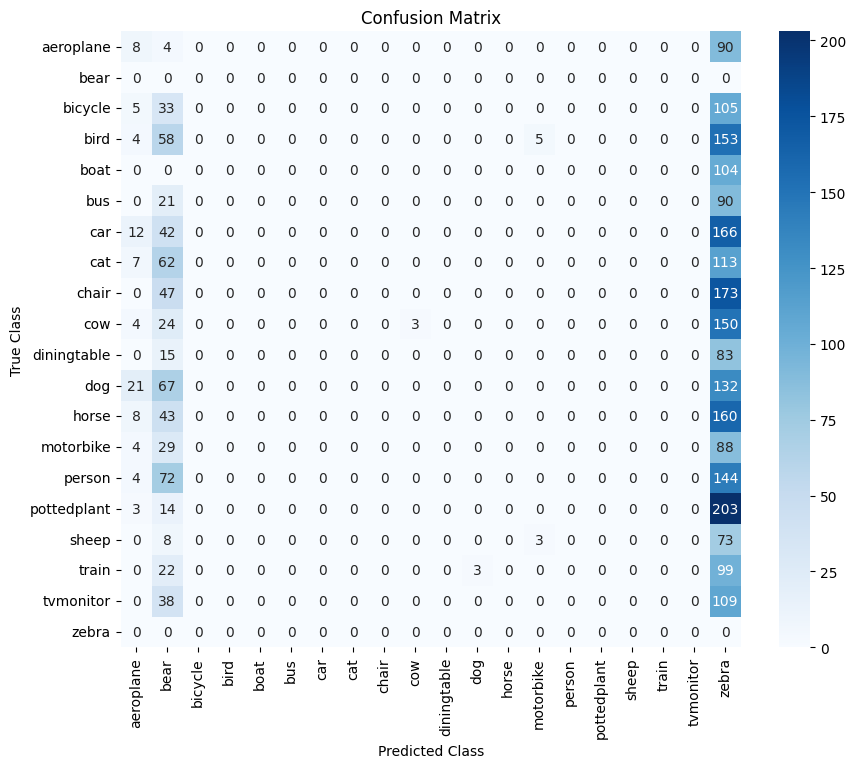

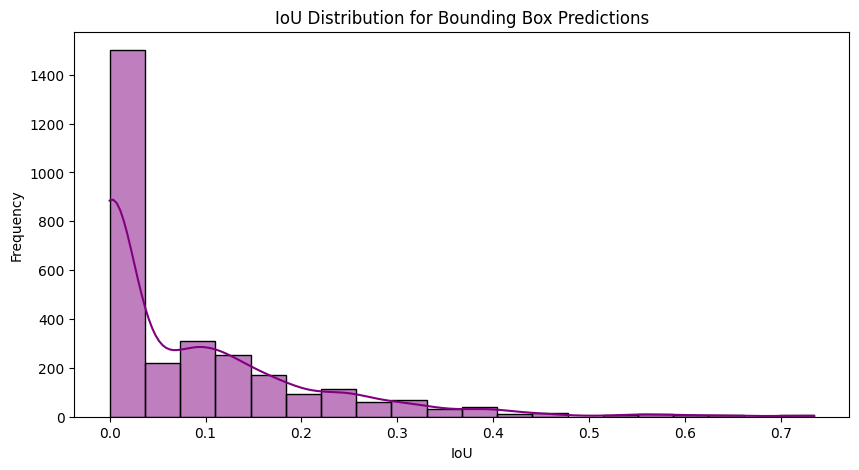

Skipping entry 0 due to invalid image path.
Skipping entry 1 due to invalid image path.
Skipping entry 2 due to invalid image path.
Skipping entry 3 due to invalid image path.
Skipping entry 4 due to invalid image path.
Classification Report:



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

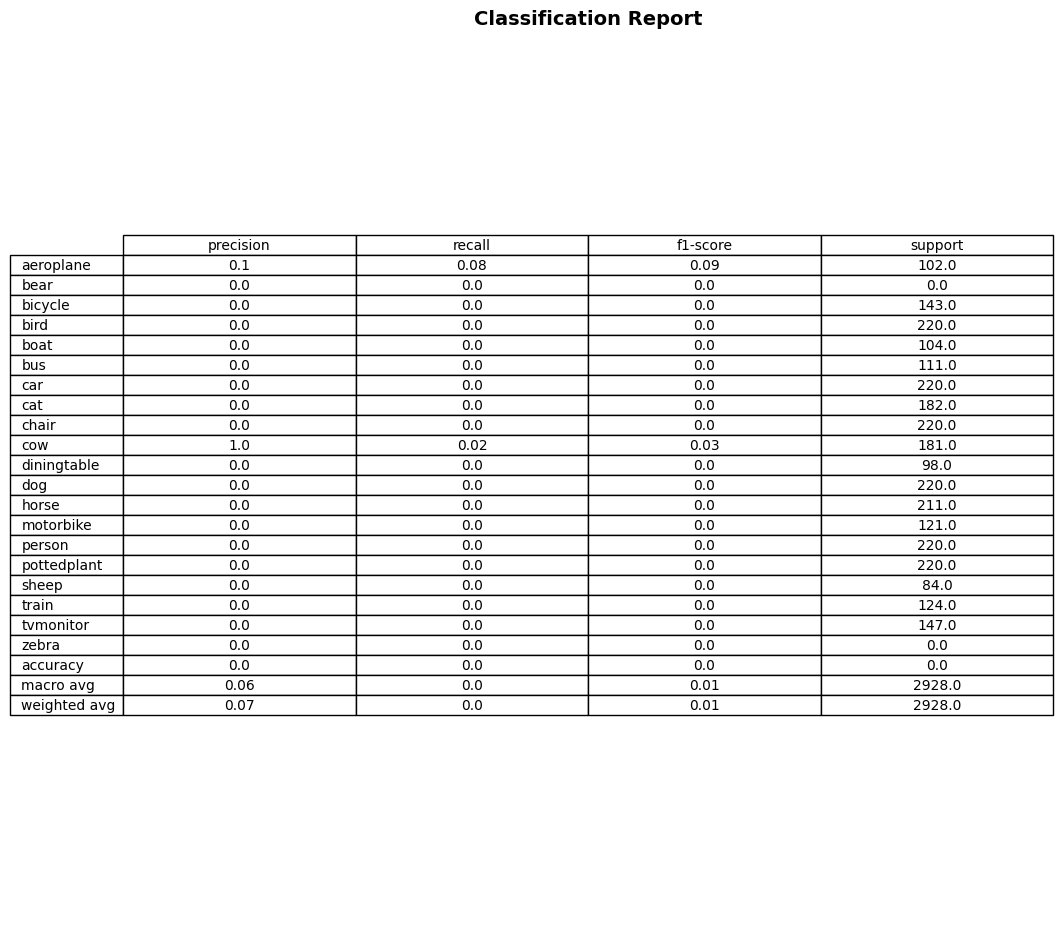

In [ ]:
import re
from ast import literal_eval
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import cv2

# Load the CSV file
data = pd.read_csv('/content/drive/MyDrive/SSD/test_results.csv')  # Update this path

# Define IoU calculation
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2

    # Calculate intersection coordinates
    xi1 = max(x1, x1_p)
    yi1 = max(y1, y1_p)
    xi2 = min(x2, x2_p)
    yi2 = min(y2, y2_p)

    # Area of intersection
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    # Area of both boxes
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)

    # Calculate IoU
    iou = inter_area / (box1_area + box2_area - inter_area + 1e-5)
    return iou


# Assuming `data` is your DataFrame with 'true_class' and 'predicted_class' columns
true_classes = data['true_class']
predicted_classes = data['predicted_class']

# Find all unique classes in both true and predicted classes
all_classes = np.unique(np.concatenate([true_classes, predicted_classes]))

# Print unique classes to verify
print("Unique True Classes:", np.unique(true_classes))
print("Unique Predicted Classes:", np.unique(predicted_classes))

# Generate confusion matrix with all possible labels to include missing classes
cm = confusion_matrix(true_classes, predicted_classes, labels=all_classes)
# Plotting with seaborn to ensure labels are included
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=all_classes, yticklabels=all_classes)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


def clean_bbox(bbox_string):
    # Clean and evaluate bounding box string safely
    bbox_string = re.sub(r'[ ,]+', ',', bbox_string).strip(',')
    try:
        return literal_eval(bbox_string)
    except (ValueError, SyntaxError):
        return None

# Apply the cleaning function
data['true_bbox'] = data['true_bbox'].apply(clean_bbox)
data['predicted_bbox'] = data['predicted_bbox'].apply(clean_bbox)

# Calculate IoU only for rows where bounding boxes are valid
ious = [
    calculate_iou(row['true_bbox'], row['predicted_bbox'])
    for _, row in data.iterrows()
    if row['true_bbox'] is not None and row['predicted_bbox'] is not None
]
data['IoU'] = ious

# Plot IoU distribution
plt.figure(figsize=(10, 5))
sns.histplot(ious, kde=True, bins=20, color='purple')
plt.title("IoU Distribution for Bounding Box Predictions")
plt.xlabel("IoU")
plt.ylabel("Frequency")
plt.show()

import cv2
import matplotlib.pyplot as plt

num_images = min(5, len(data))  # Display up to 5 samples

for idx in range(num_images):
    row = data.iloc[idx]
    image_path = row['image']

    # Verify that image_path is a valid string
    if not isinstance(image_path, str) or not image_path:
        print(f"Skipping entry {idx} due to invalid image path.")
        continue

    # Ensure bounding boxes are in list format or convert them
    try:
        true_box = row['true_bbox'] if isinstance(row['true_bbox'], list) else eval(row['true_bbox'])
        pred_box = row['predicted_bbox'] if isinstance(row['predicted_bbox'], list) else eval(row['predicted_bbox'])
    except Exception as e:
        print(f"Skipping entry {idx} due to invalid bounding box format: {e}")
        continue

    # Verify that bounding boxes are in the expected format
    if true_box is None or pred_box is None:
        print(f"Skipping image {image_path} due to invalid bounding boxes.")
        continue

    # Read and process the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image {image_path} not found.")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes on the image
    cv2.rectangle(img, (true_box[0], true_box[1]), (true_box[2], true_box[3]), (0, 255, 0), 2)  # Green for true box
    cv2.rectangle(img, (pred_box[0], pred_box[1]), (pred_box[2], pred_box[3]), (255, 0, 0), 2)  # Red for predicted box

    # Display the image with bounding boxes
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Image: {image_path}\nTrue Class: {row['true_class']} | Predicted Class: {row['predicted_class']}\nIoU: {row.get('IoU', 'N/A'):.2f}")
    plt.axis("off")
    plt.show()

# Combine unique classes from both true and predicted classes
all_classes = np.unique(np.concatenate([true_classes, predicted_classes]))

# Generate classification report with all classes
print("Classification Report:\n")
report_dict = classification_report(true_classes, predicted_classes, target_names=all_classes, labels=all_classes, output_dict=True)
# Convert the dictionary to a DataFrame for easier handling
report_df = pd.DataFrame(report_dict).transpose()
# Plot the classification report as a table
plt.figure(figsize=(10, len(report_df) * 0.5))
plt.axis('off')
table = plt.table(cellText=report_df.round(2).values,
                  colLabels=report_df.columns,
                  rowLabels=report_df.index,
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.title("Classification Report", fontsize=14, weight='bold')
plt.show()

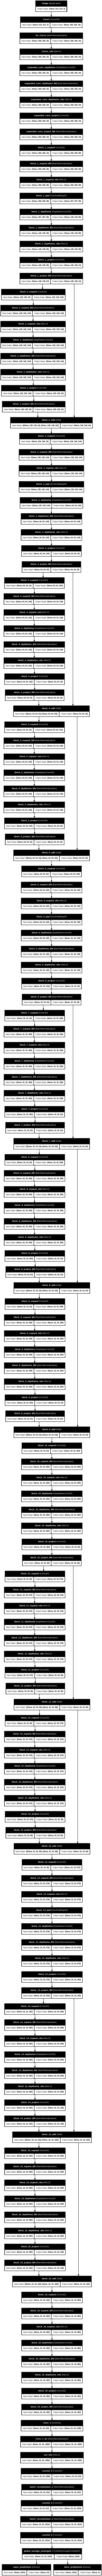

In [ ]:
from tensorflow.keras.utils import plot_model
import IPython.display as display

# Path to save the model diagram
model_diagram_path = "/content/drive/MyDrive/SSD/model_diagram.png"

# Plot and save the model diagram
plot_model(
    ssd_model,                       # Your model variable
    to_file=model_diagram_path,      # File path to save the diagram
    show_shapes=True,                # Display layer shapes in the diagram
    show_layer_names=True,           # Display layer names in the diagram
    dpi=96,                          # Set the resolution (dpi) for better clarity
    expand_nested=True               # Expand nested models if any (optional)
)

# Display the model diagram in Google Colab or Jupyter Notebook
display.Image(filename=model_diagram_path)